# init

In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # for XGBoost
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt 

from sklearn.ensemble        import RandomForestClassifier
from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from catboost                import CatBoostClassifier
from sklearn.linear_model    import LogisticRegression

from sklearn                 import datasets, metrics
from sklearn.model_selection import train_test_split
from umap                    import UMAP


In [31]:
# import domestic lib
import ppap.tabular_util   as ppap_tab_ut
import ppap.tabular_2class as ppap_tab_2c

import importlib
importlib.reload(ppap_tab_ut)
importlib.reload(ppap_tab_2c)


<module 'ppap.tabular_2class' from '/Users/mucunwuxian/MICIN/20190705_houken_and_PPAP/PPAP/ppap/tabular_2class.py'>

In [5]:
# 
input_csv_dir  = './data/titanic'
 
# 
output_log_dir = './log'

# 
os.makedirs(output_log_dir, exist_ok=True)


In [6]:
# pandas display option (ajustable)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

#
np.set_printoptions(threshold=2000)

# 
plt.rcParams["font.size"] = 12


# Pre-Process

data download from https://www.kaggle.com/c/titanic/data<br>
ref https://qiita.com/suzumi/items/8ce18bc90c942663d1e6

In [7]:
# load titanic data from kaggle
df_Xy       = pd.read_csv('%s/train.csv' % input_csv_dir)
column_name = df_Xy.columns

#
print(df_Xy.shape)
df_Xy.head(5)


(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


[info]<br>
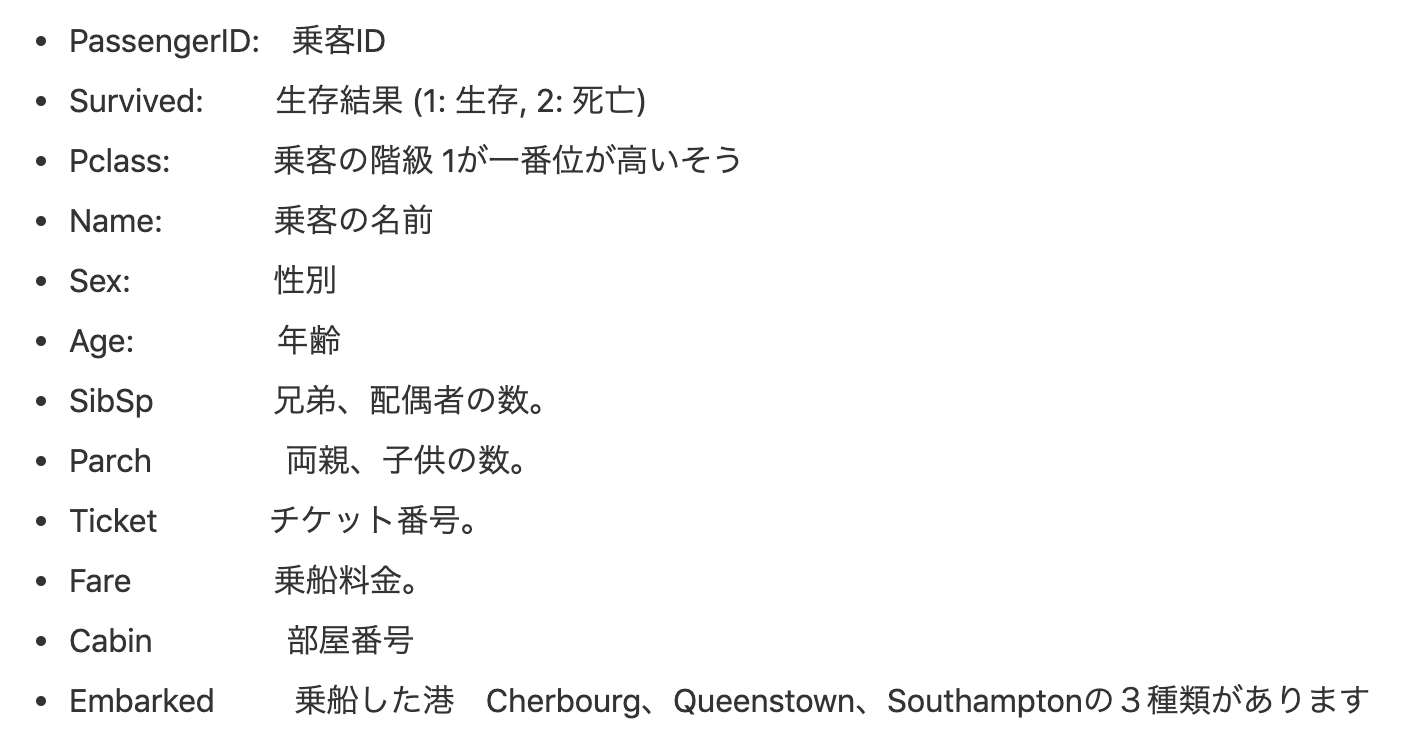


include nan column is ...

------------------------------------------------------------
  - Age -> 0.19865
  - Cabin -> 0.77104
  - Embarked -> 0.00224


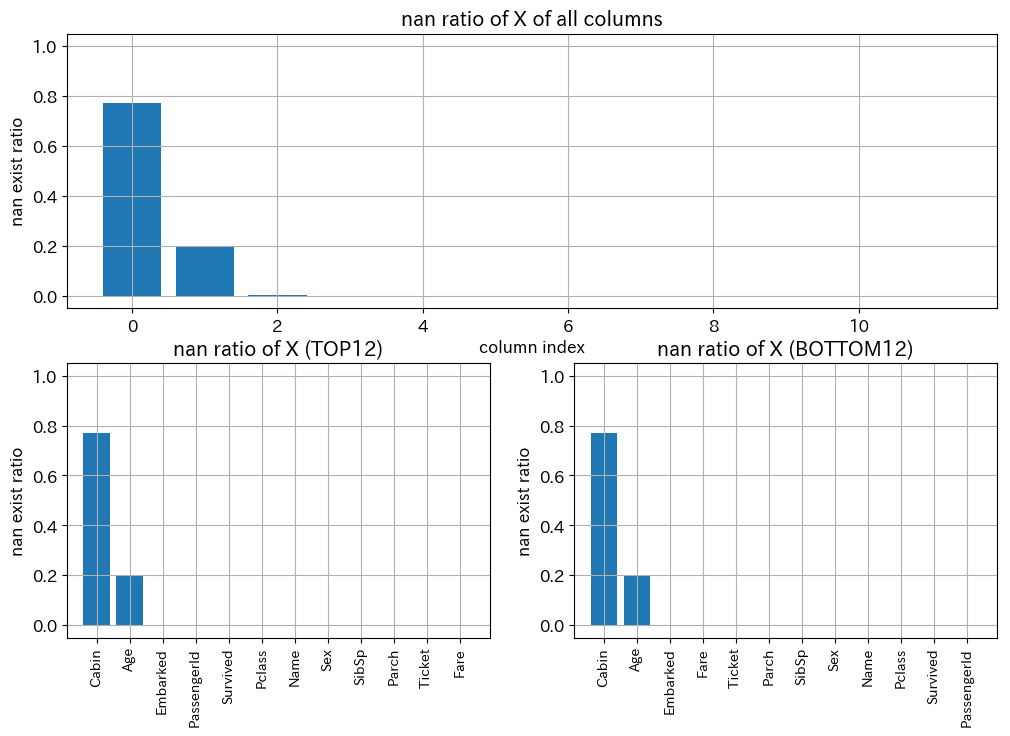

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.1986532 , 0.        , 0.        , 0.        , 0.        ,
       0.77104377, 0.00224467])

In [8]:
# [STEP 1]
# check nan ratio (vertical)
ppap_tab_ut.check_nan_ratio_vert(X = df_Xy)


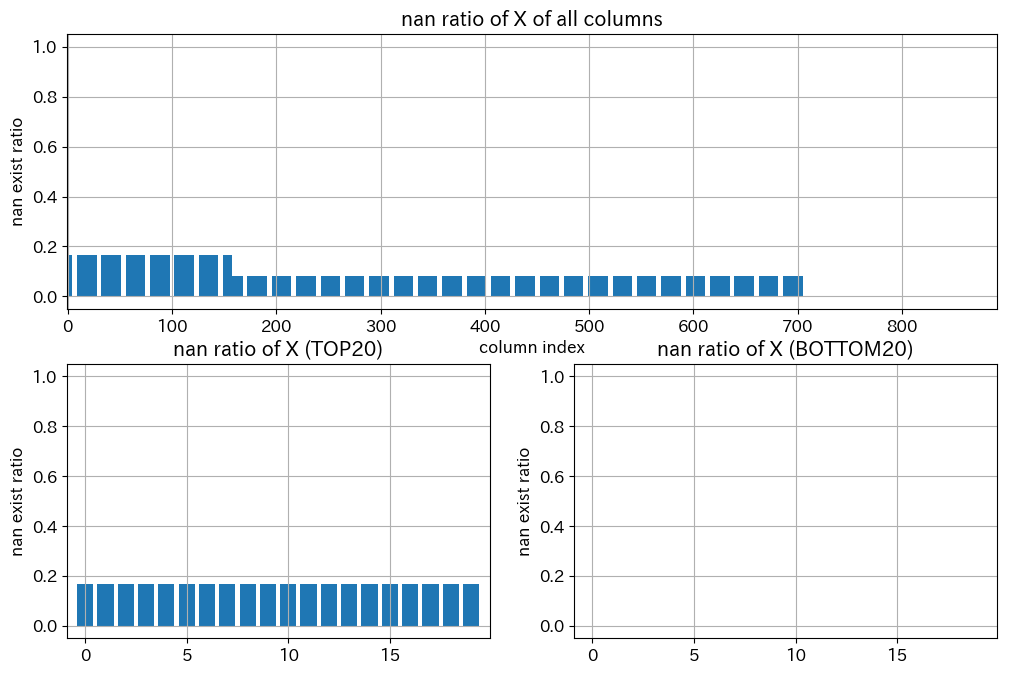

In [9]:
# [STEP 2]
# check nan ratio (horizontal)
nan_ratio = ppap_tab_ut.check_nan_ratio_horz(X = df_Xy)


In [10]:
# [STEP 3]
# value state check
ppap_tab_ut.check_value_count(X = df_Xy)



numeric ratio is ...

------------------------------------------------------------
  - PassengerId -> 1.00000
  - Survived -> 1.00000
  - Pclass -> 1.00000
  - Name -> 0.00000
  - Sex -> 0.00000
  - Age -> 1.00000
  - SibSp -> 1.00000
  - Parch -> 1.00000
  - Ticket -> 0.74186
  - Fare -> 1.00000
  - Cabin -> 0.00000
  - Embarked -> 0.00000



value pattern is ...

------------------------------------------------------------
[PassengerId]
891    1
293    1
304    1
303    1
302    1
301    1
300    1
299    1
298    1
297    1
296    1
295    1
294    1
292    1
306    1
291    1
290    1
289    1
288    1
287    1
286    1
285    1
284    1
283    1
282    1
281    1
305    1
307    1
279    1
321    1
332    1
331    1
330    1
329    1
328    1
327    1
326    1
325    1
324    1
323    1
322    1
320    1
308    1
319    1
318    1
317    1
316    1
315    1
314    1
313    1
312    1
311    1
310    1
309    1
280    1
278    1
223    1
237    1
248    1
247    1
246    1
245    

In [11]:
# [STEP 4]
# organize data

# 
print('\nbefore organize shape is (%d, %d)' % np.shape(df_Xy))
# exec
df_Xy = ppap_tab_ut.organize_data(X = df_Xy)
# 
print('\nafter organize shape is (%d, %d)' % np.shape(df_Xy))
df_Xy.head(10)



before organize shape is (891, 12)

delete one-pattern column...
  - none ...

delete overlap column...
  - none ...

after organize shape is (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,NaN,C


In [12]:
# [STEP 5]
# quantize

# column assign
column_1k   = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
column_disc = ['Age', 'Fare']
column_bow  = []

# exec
df_Xy_, _ = ppap_tab_ut.one_k_code_and_disc(X             = df_Xy, 
                                            column_1k     = column_1k, 
                                            column_disc   = column_disc,
                                            column_bow    = column_bow,  
                                            disc_bins_num = 50)
# view
df_Xy_.head(10)



1-k conding or discretization [start time is 2019-07-09 18:54:00.734750]
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
                              [end time is 2019-07-09 18:54:01.288918]



after quantize size = (891, 123)


,Pclass_c[1],Pclass_c[2],Pclass_c[3],Sex_c[female],Age_c[(nan)],Age_v[0.000-1.600],Age_v[1.600-3.200],Age_v[3.200-4.800],Age_v[4.800-6.400],Age_v[6.400-8.000],Age_v[8.000-9.600],Age_v[9.600-11.200],Age_v[11.200-12.800],Age_v[12.800-14.400],Age_v[14.400-16.000],Age_v[16.000-17.600],Age_v[17.600-19.200],Age_v[19.200-20.800],Age_v[20.800-22.400],Age_v[22.400-24.000],Age_v[24.000-25.600],Age_v[25.600-27.200],Age_v[27.200-28.800],Age_v[28.800-30.400],Age_v[30.400-32.000],Age_v[32.000-33.600],Age_v[33.600-35.200],Age_v[35.200-36.800],Age_v[36.800-38.400],Age_v[38.400-40.000],Age_v[40.000-41.600],Age_v[41.600-43.200],Age_v[43.200-44.800],Age_v[44.800-46.400],Age_v[46.400-48.000],Age_v[48.000-49.600],Age_v[49.600-51.200],Age_v[51.200-52.800],Age_v[52.800-54.400],Age_v[54.400-56.000],Age_v[56.000-57.600],Age_v[57.600-59.200],Age_v[59.200-60.800],Age_v[60.800-62.400],Age_v[62.400-64.000],Age_v[64.000-65.600],Age_v[65.600-67.200],Age_v[67.200-68.800],Age_v[68.800-70.400],Age_v[70.400-72.000],Age_v[72.000-73.600],Age_v[73.600-75.200],Age_v[75.200-76.800],Age_v[76.800-78.400],Age_v[78.400-80.000],SibSp_c[0],SibSp_c[1],SibSp_c[2],SibSp_c[3],SibSp_c[4],SibSp_c[5],SibSp_c[8],Parch_c[0],Parch_c[1],Parch_c[2],Parch_c[3],Parch_c[4],Parch_c[5],Parch_c[6],Fare_v[0.000-10.247],Fare_v[10.247-20.493],Fare_v[20.493-30.740],Fare_v[30.740-40.986],Fare_v[40.986-51.233],Fare_v[51.233-61.480],Fare_v[61.480-71.726],Fare_v[71.726-81.973],Fare_v[81.973-92.219],Fare_v[92.219-102.466],Fare_v[102.466-112.712],Fare_v[112.712-122.959],Fare_v[122.959-133.206],Fare_v[133.206-143.452],Fare_v[143.452-153.699],Fare_v[153.699-163.945],Fare_v[163.945-174.192],Fare_v[174.192-184.439],Fare_v[184.439-194.685],Fare_v[194.685-204.932],Fare_v[204.932-215.178],Fare_v[215.178-225.425],Fare_v[225.425-235.671],Fare_v[235.671-245.918],Fare_v[245.918-256.165],Fare_v[256.165-266.411],Fare_v[266.411-276.658],Fare_v[276.658-286.904],Fare_v[286.904-297.151],Fare_v[297.151-307.398],Fare_v[307.398-317.644],Fare_v[317.644-327.891],Fare_v[327.891-338.137],Fare_v[338.137-348.384],Fare_v[348.384-358.630],Fare_v[358.630-368.877],Fare_v[368.877-379.124],Fare_v[379.124-389.370],Fare_v[389.370-399.617],Fare_v[399.617-409.863],Fare_v[409.863-420.110],Fare_v[420.110-430.357],Fare_v[430.357-440.603],Fare_v[440.603-450.850],Fare_v[450.850-461.096],Fare_v[461.096-471.343],Fare_v[471.343-481.589],Fare_v[481.589-491.836],Fare_v[491.836-502.083],Fare_v[502.083-512.329],Embarked_c[(nan)],Embarked_c[c],Embarked_c[q],Embarked_c[s]
0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
1,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
2,0,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
3,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [13]:
# [STEP 6]
# treatment
column_y    = 'Survived'

column_name = df_Xy_.columns
X           = df_Xy_.values
y           = df_Xy.loc[:, column_y].values.astype('float')

# print size of X and y
print('column_name = \n%s(%d)' % (column_name, len(column_name)))
print('np.shape(X) = (%d, %d)' % np.shape(X))
print('np.shape(y) = (%d)'     % np.shape(y))

# for visualize
df_X_tmp = pd.DataFrame(X, columns=column_name)
df_X_tmp.head(10)


column_name = 
Index(['Pclass_c[1]', 'Pclass_c[2]', 'Pclass_c[3]', 'Sex_c[female]',
       'Age_c[(nan)]', 'Age_v[0.000-1.600]', 'Age_v[1.600-3.200]',
       'Age_v[3.200-4.800]', 'Age_v[4.800-6.400]', 'Age_v[6.400-8.000]',
       ...
       'Fare_v[450.850-461.096]', 'Fare_v[461.096-471.343]',
       'Fare_v[471.343-481.589]', 'Fare_v[481.589-491.836]',
       'Fare_v[491.836-502.083]', 'Fare_v[502.083-512.329]',
       'Embarked_c[(nan)]', 'Embarked_c[c]', 'Embarked_c[q]', 'Embarked_c[s]'],
      dtype='object', length=123)(123)
np.shape(X) = (891, 123)
np.shape(y) = (891)


,Pclass_c[1],Pclass_c[2],Pclass_c[3],Sex_c[female],Age_c[(nan)],Age_v[0.000-1.600],Age_v[1.600-3.200],Age_v[3.200-4.800],Age_v[4.800-6.400],Age_v[6.400-8.000],Age_v[8.000-9.600],Age_v[9.600-11.200],Age_v[11.200-12.800],Age_v[12.800-14.400],Age_v[14.400-16.000],Age_v[16.000-17.600],Age_v[17.600-19.200],Age_v[19.200-20.800],Age_v[20.800-22.400],Age_v[22.400-24.000],Age_v[24.000-25.600],Age_v[25.600-27.200],Age_v[27.200-28.800],Age_v[28.800-30.400],Age_v[30.400-32.000],Age_v[32.000-33.600],Age_v[33.600-35.200],Age_v[35.200-36.800],Age_v[36.800-38.400],Age_v[38.400-40.000],Age_v[40.000-41.600],Age_v[41.600-43.200],Age_v[43.200-44.800],Age_v[44.800-46.400],Age_v[46.400-48.000],Age_v[48.000-49.600],Age_v[49.600-51.200],Age_v[51.200-52.800],Age_v[52.800-54.400],Age_v[54.400-56.000],Age_v[56.000-57.600],Age_v[57.600-59.200],Age_v[59.200-60.800],Age_v[60.800-62.400],Age_v[62.400-64.000],Age_v[64.000-65.600],Age_v[65.600-67.200],Age_v[67.200-68.800],Age_v[68.800-70.400],Age_v[70.400-72.000],Age_v[72.000-73.600],Age_v[73.600-75.200],Age_v[75.200-76.800],Age_v[76.800-78.400],Age_v[78.400-80.000],SibSp_c[0],SibSp_c[1],SibSp_c[2],SibSp_c[3],SibSp_c[4],SibSp_c[5],SibSp_c[8],Parch_c[0],Parch_c[1],Parch_c[2],Parch_c[3],Parch_c[4],Parch_c[5],Parch_c[6],Fare_v[0.000-10.247],Fare_v[10.247-20.493],Fare_v[20.493-30.740],Fare_v[30.740-40.986],Fare_v[40.986-51.233],Fare_v[51.233-61.480],Fare_v[61.480-71.726],Fare_v[71.726-81.973],Fare_v[81.973-92.219],Fare_v[92.219-102.466],Fare_v[102.466-112.712],Fare_v[112.712-122.959],Fare_v[122.959-133.206],Fare_v[133.206-143.452],Fare_v[143.452-153.699],Fare_v[153.699-163.945],Fare_v[163.945-174.192],Fare_v[174.192-184.439],Fare_v[184.439-194.685],Fare_v[194.685-204.932],Fare_v[204.932-215.178],Fare_v[215.178-225.425],Fare_v[225.425-235.671],Fare_v[235.671-245.918],Fare_v[245.918-256.165],Fare_v[256.165-266.411],Fare_v[266.411-276.658],Fare_v[276.658-286.904],Fare_v[286.904-297.151],Fare_v[297.151-307.398],Fare_v[307.398-317.644],Fare_v[317.644-327.891],Fare_v[327.891-338.137],Fare_v[338.137-348.384],Fare_v[348.384-358.630],Fare_v[358.630-368.877],Fare_v[368.877-379.124],Fare_v[379.124-389.370],Fare_v[389.370-399.617],Fare_v[399.617-409.863],Fare_v[409.863-420.110],Fare_v[420.110-430.357],Fare_v[430.357-440.603],Fare_v[440.603-450.850],Fare_v[450.850-461.096],Fare_v[461.096-471.343],Fare_v[471.343-481.589],Fare_v[481.589-491.836],Fare_v[491.836-502.083],Fare_v[502.083-512.329],Embarked_c[(nan)],Embarked_c[c],Embarked_c[q],Embarked_c[s]
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0

In [14]:
# # [STEP 7]
# # regularization
# X_reg, X_min, X_max = ppap_tab_ut.X_regularization(X)

# # 
# print('np.shape(X) = (%d, %d)' % np.shape(X_reg))
# print('min = ')
# print(np.min(X_reg, axis=0))
# print('max = ')
# print(np.max(X_reg, axis=0))


In [15]:
# # [STEP 8]
# # make co-occurrence feat
# X, column_name = ppap_tab_ut.cooc_feat(X           = X_reg, 
#                                        column_name = column_name)

# # print size of X and y
# print('column_name = \n%s(%d)' % (column_name, len(column_name)))
# print('np.shape(X) = (%d, %d)' % np.shape(X))

# # for visualize
# df_X_tmp = pd.DataFrame(X, columns=column_name)
# df_X_tmp.head(10)


Total data num    :    891件
Positive data num :    342件 (38.38%)
Negative data num :    549件 (61.62%)


leakage check


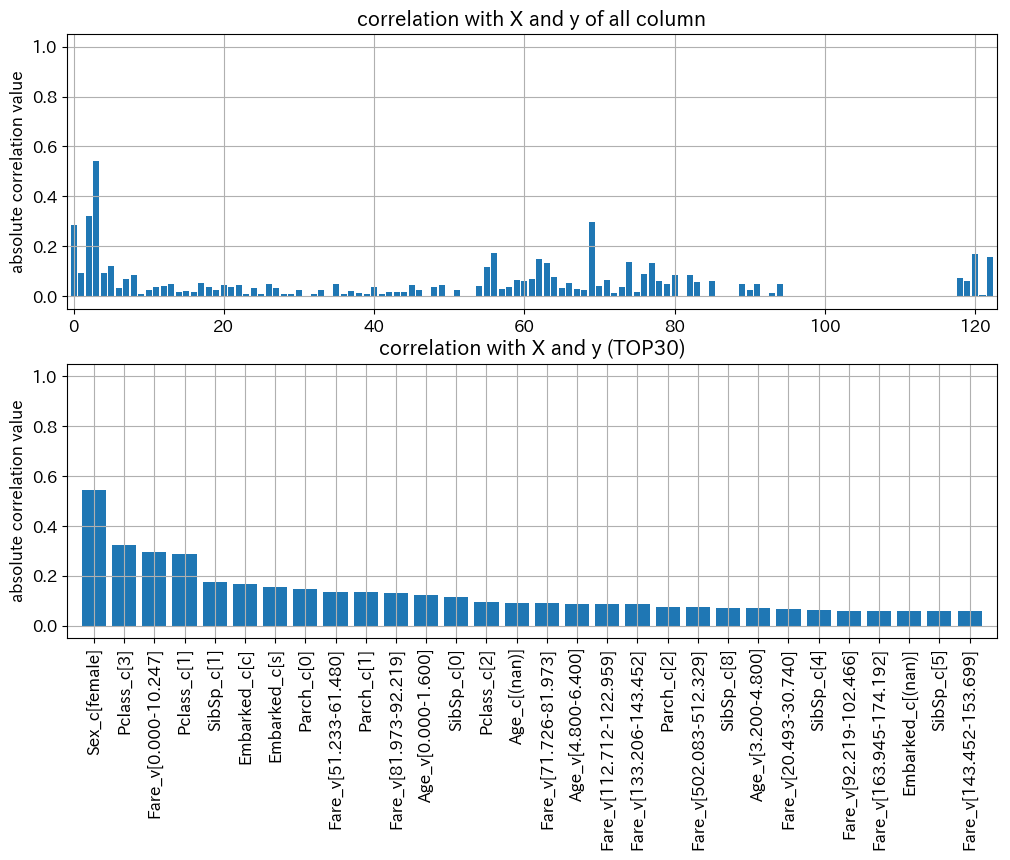



cross plot
(high corr TOP10)
---------------------------------------------
[3]


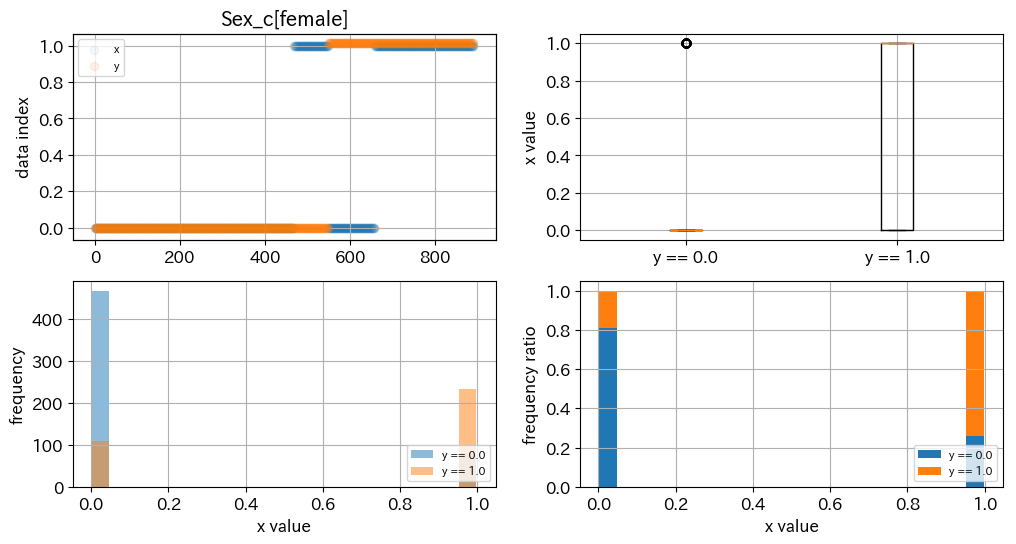



---------------------------------------------
[2]


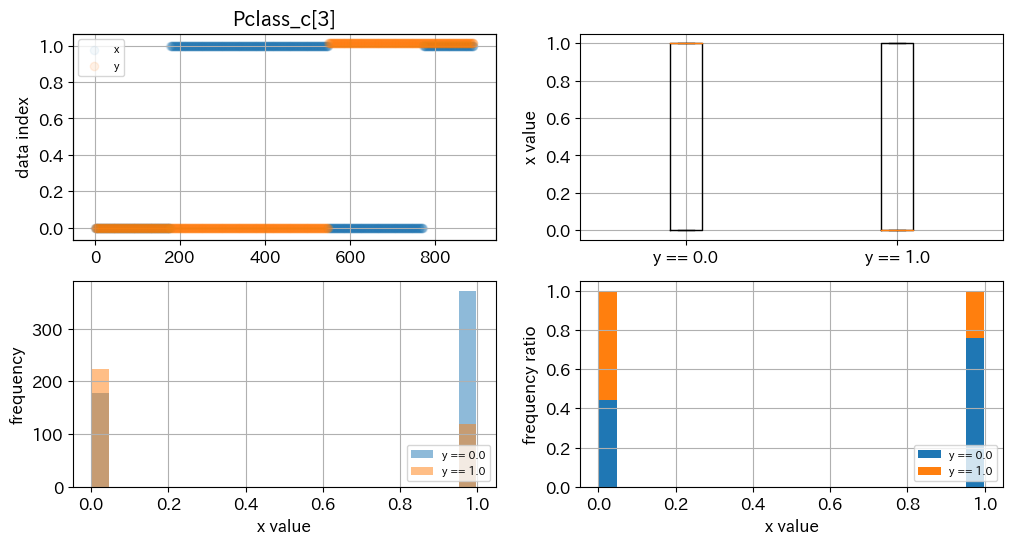



---------------------------------------------
[69]


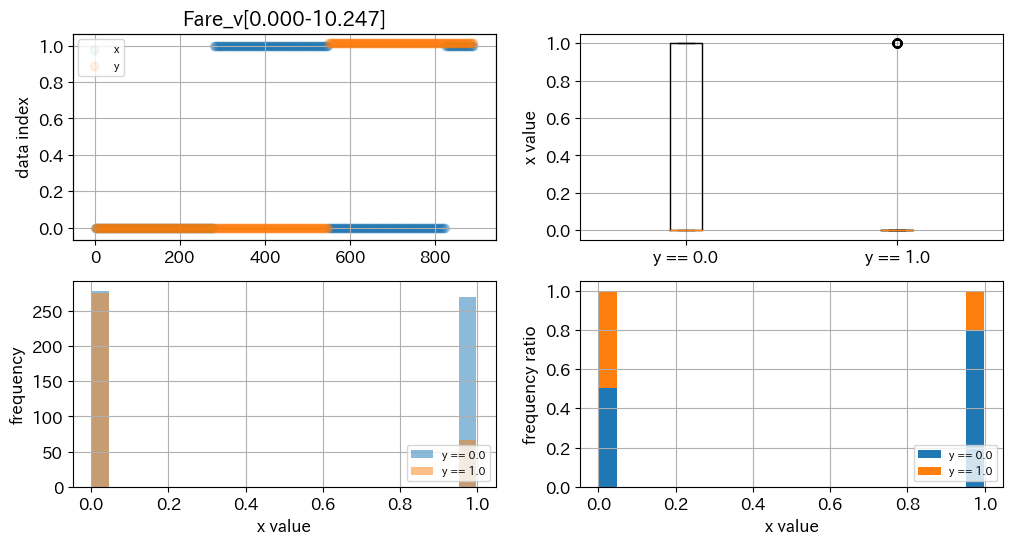



---------------------------------------------
[0]


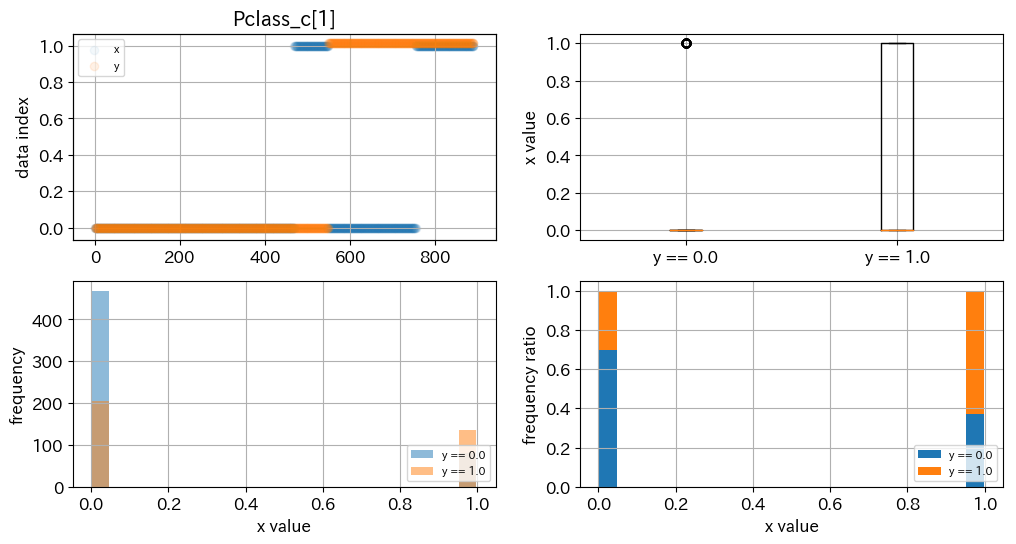



---------------------------------------------
[56]


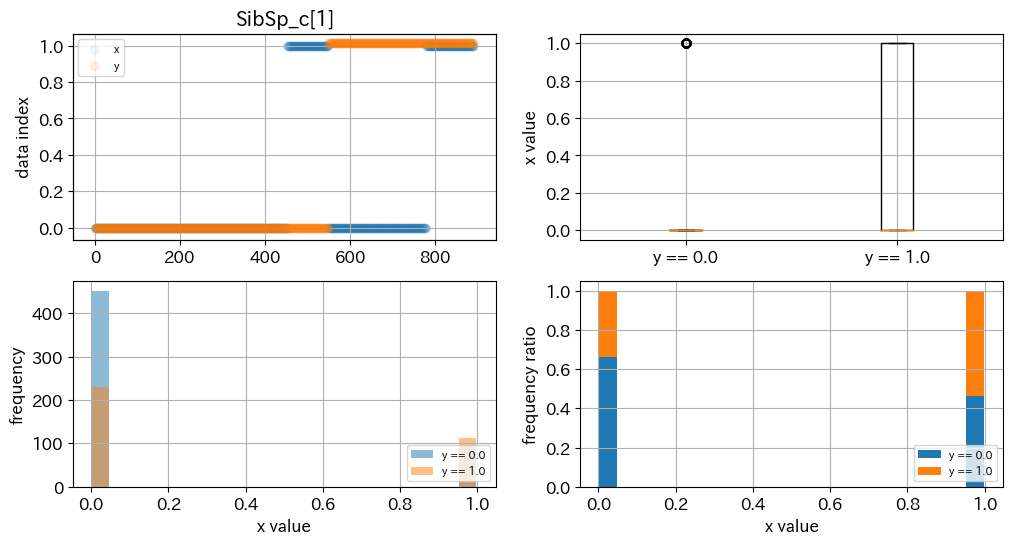



---------------------------------------------
[120]


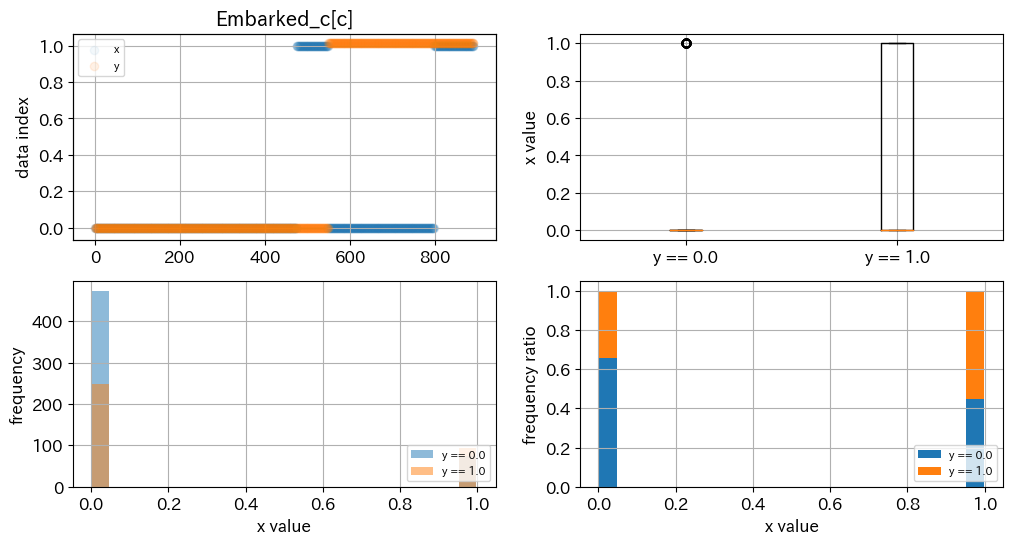



---------------------------------------------
[122]


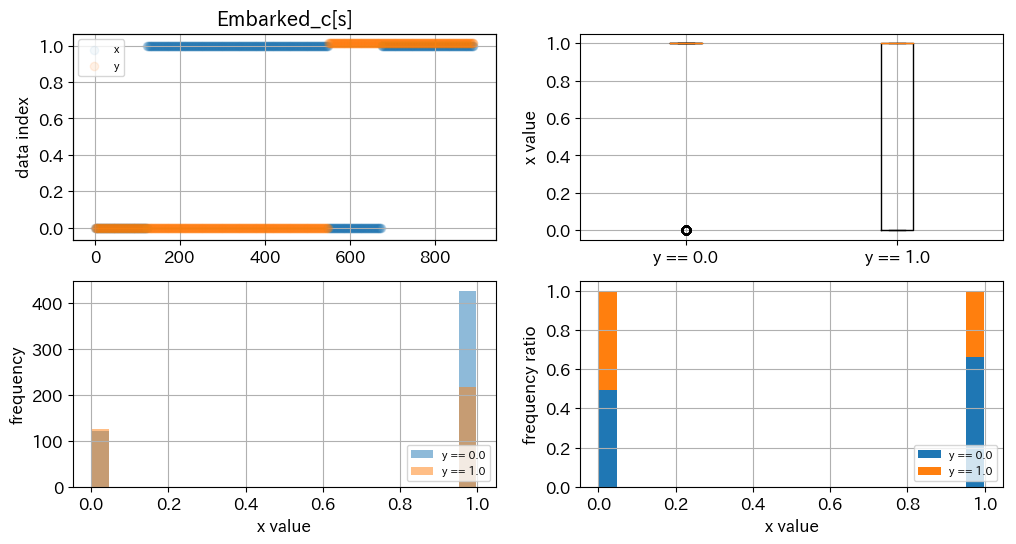



---------------------------------------------
[62]


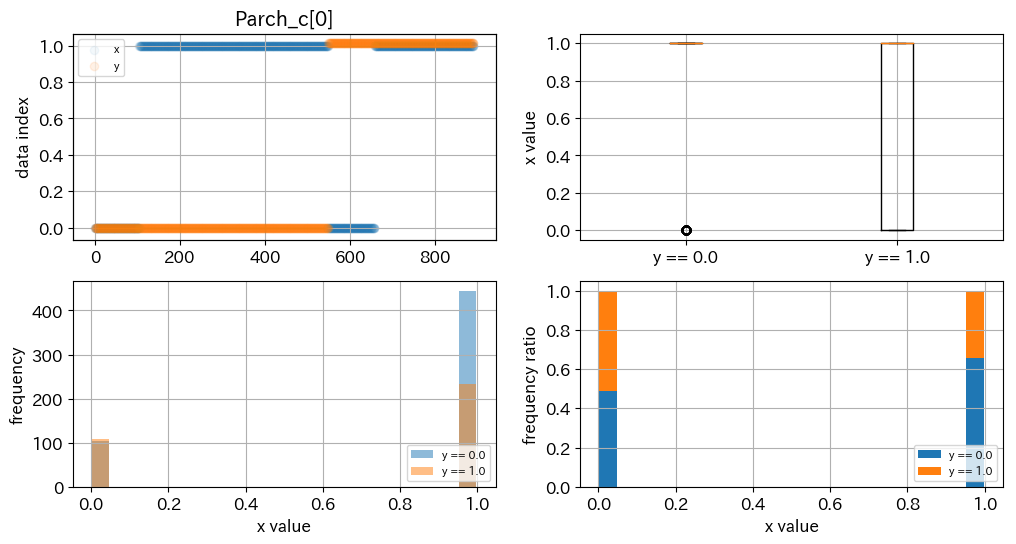



---------------------------------------------
[74]


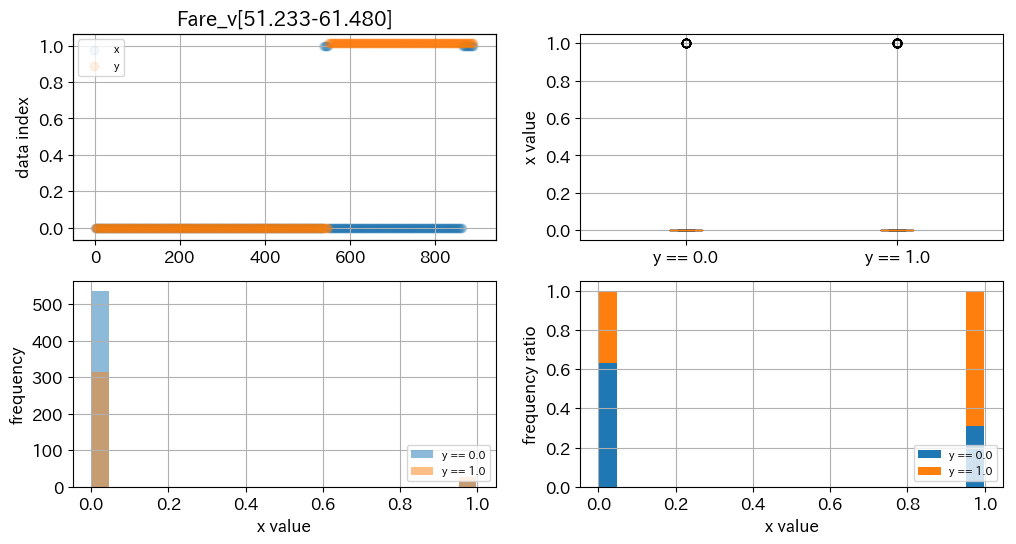



---------------------------------------------
[63]


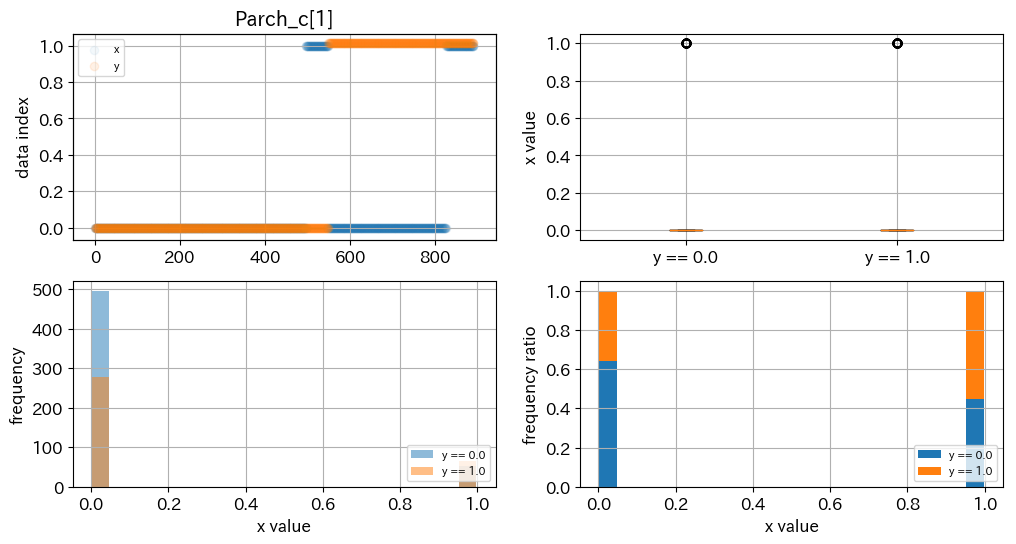



Total data num    :    891件
Positive data num :    342件 (38.38%)
Negative data num :    549件 (61.62%)


leakage check


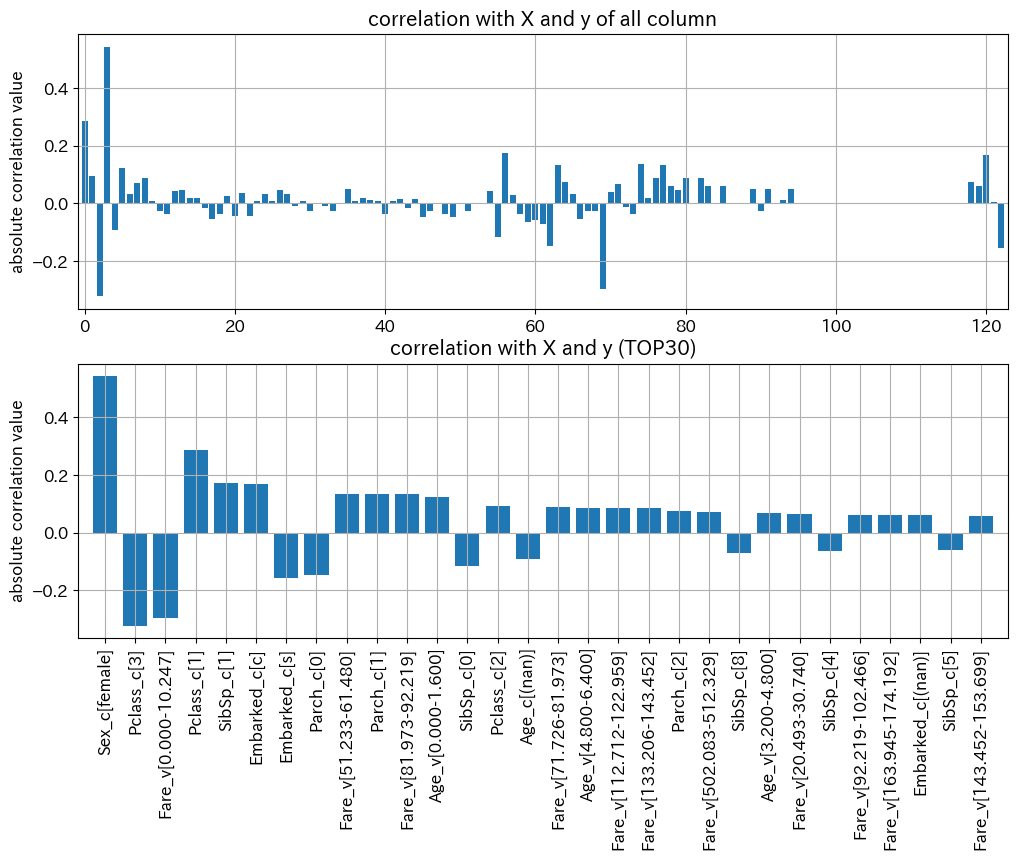

In [20]:
# [STEP 9]
# check leakage
corr_with_y = ppap_tab_ut.check_X_and_y_status(X           = X, 
                                               y           = y, 
                                               column_name = column_name)

_ = ppap_tab_ut.check_X_and_y_status(X           = X, 
                                     y           = y, 
                                     column_name = column_name, 
                                     abs_flg     = False, 
                                     cross_plot  = False)


2dim visualization


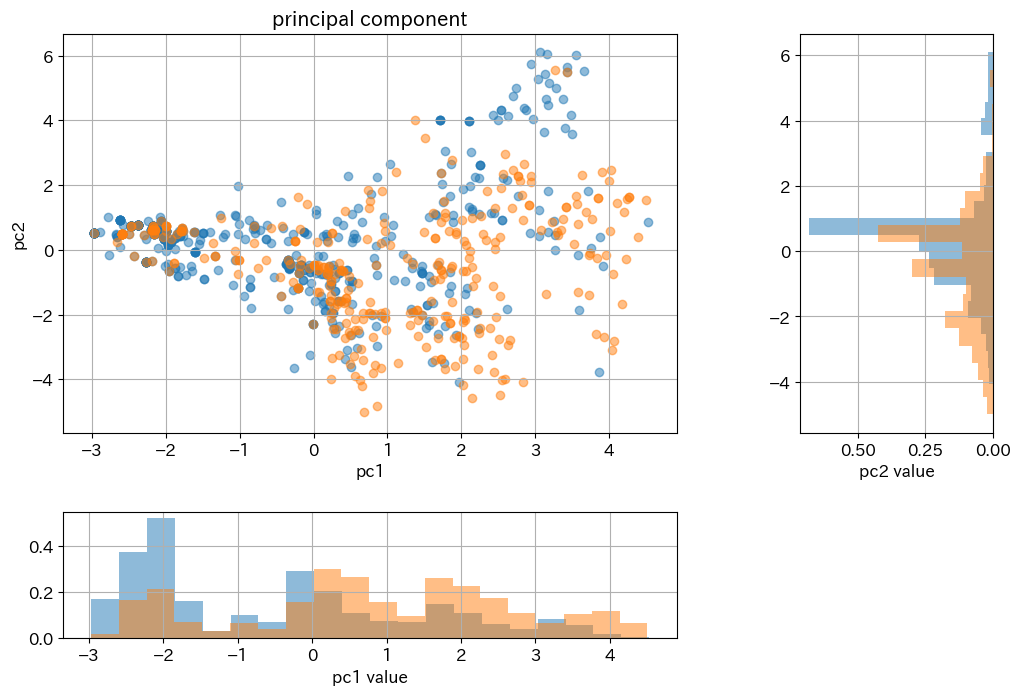

2dim visualization


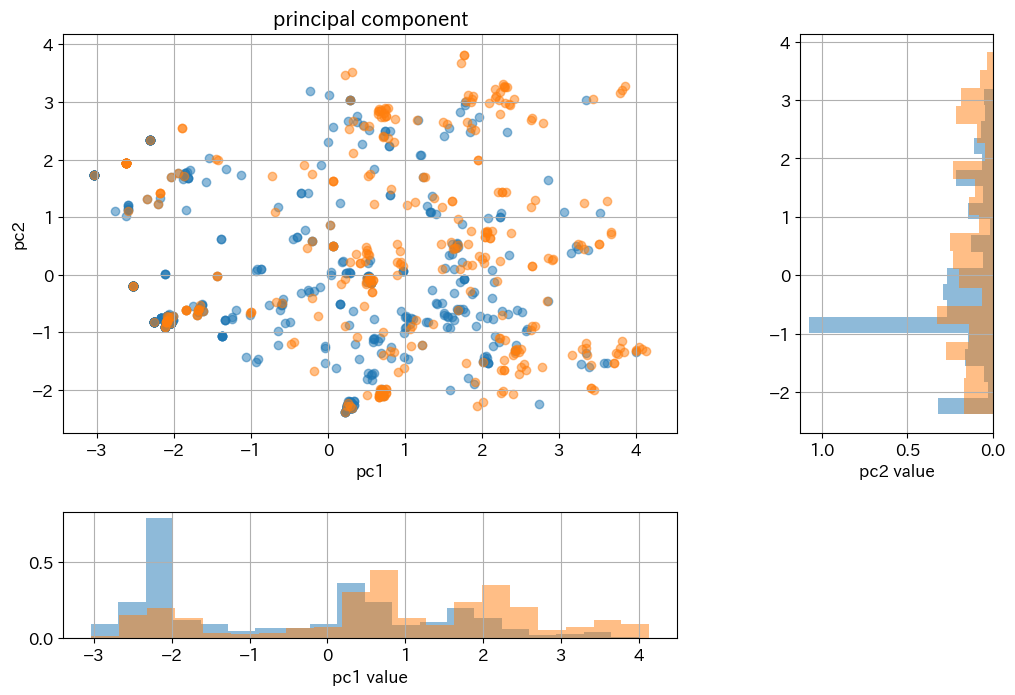

In [21]:
# [STEP 10-1]
# visualize on PCA
_, _, _ = ppap_tab_ut.understandable_visualize(X = X, 
                                               y = y)

# visualize on PCA (suppress outlier)
_, _, _ = ppap_tab_ut.understandable_visualize(X              = X, 
                                               y              = y, 
                                               X_outlier_care = True)


2dim visualization


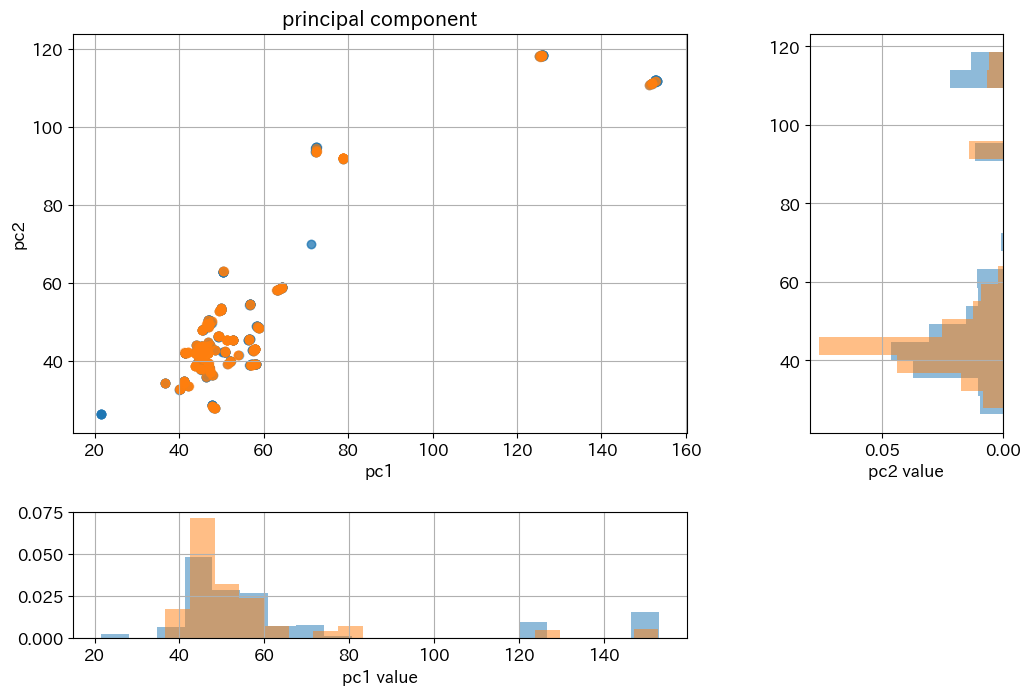

2dim visualization


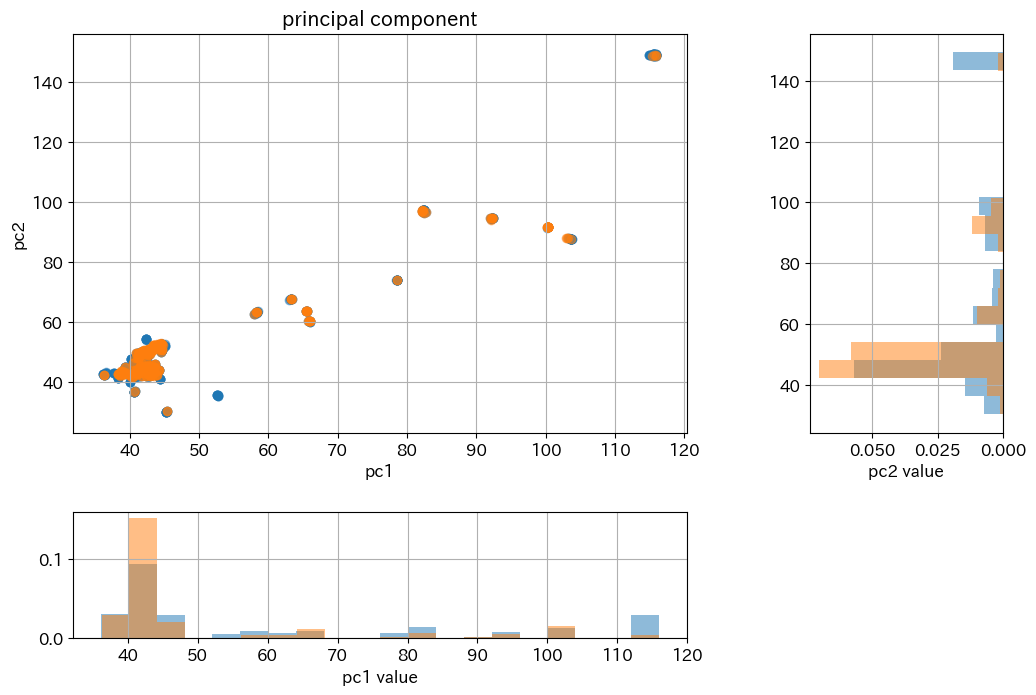

In [22]:
# [STEP 10-2]
# visualize on UMAP
_, _, _ = ppap_tab_ut.understandable_visualize(X     = X, 
                                               y     = y, 
                                               model = UMAP(random_state=0))

# visualize on UMAP (suppress outlier)
_, _, _ = ppap_tab_ut.understandable_visualize(X              = X, 
                                               y              = y,
                                               model          = UMAP(random_state=0),
                                               X_outlier_care = True)


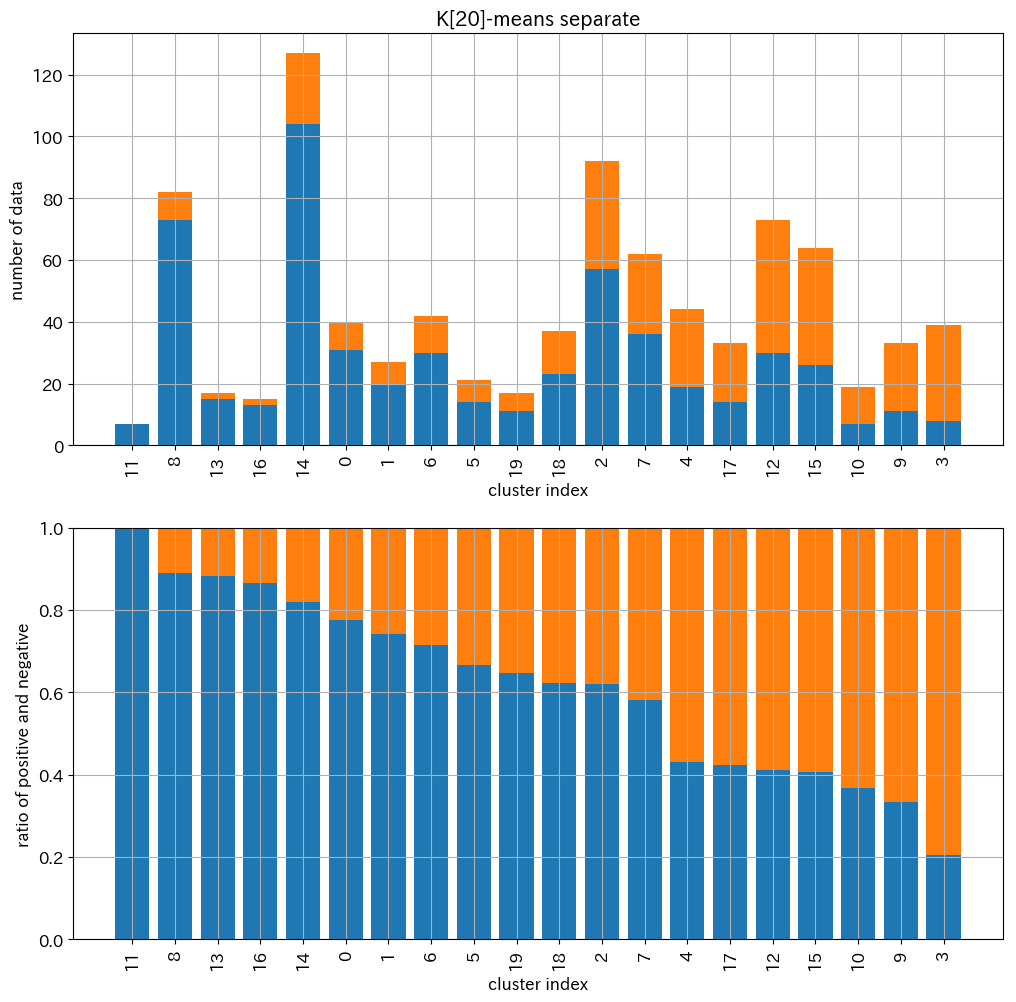

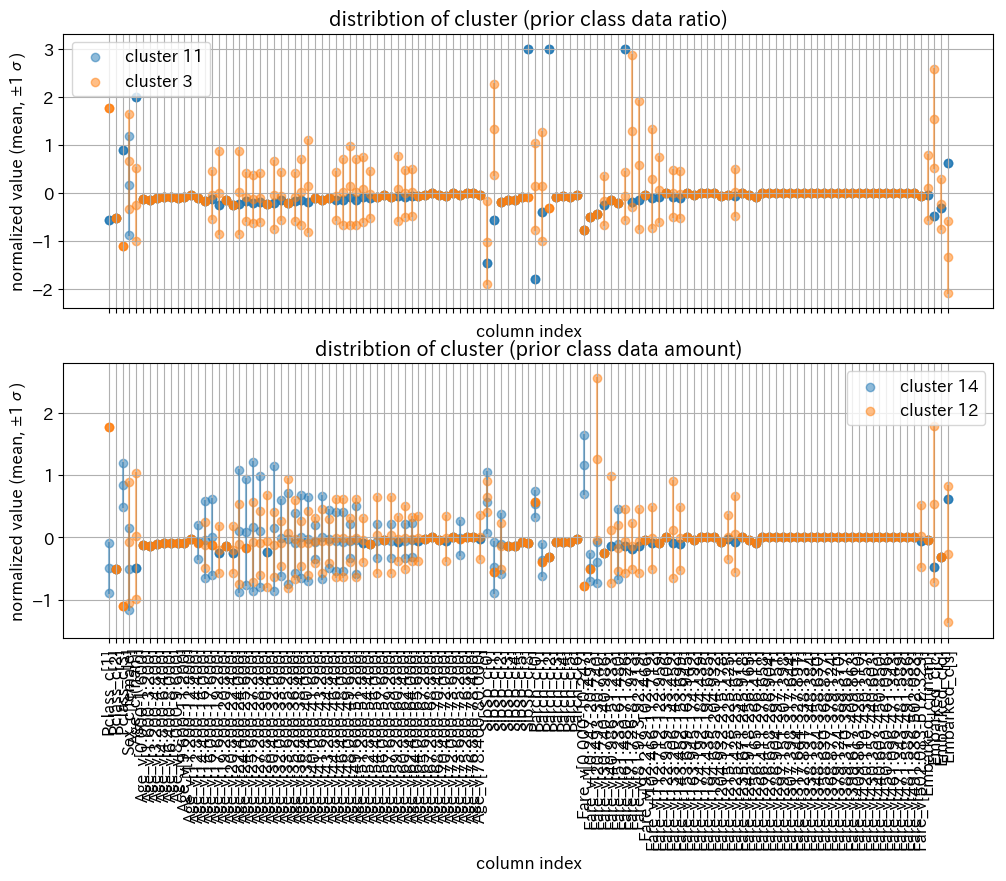

In [25]:
# [STEP 11] 
# judge predictable or not by kmeans
(kmeans_result, 
 _, 
 idx_sort_k) = ppap_tab_ut.kmeans_classification(X              = X, 
                                                 y              = y, 
                                                 column_name    = column_name, 
                                                 k              = 20, 
                                                 X_outlier_care = True)


k-nn searching on positive data [start time is 2019-07-09 19:03:08.515317]
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
                                [end time is 2019-07-09 19:03:10.402081]



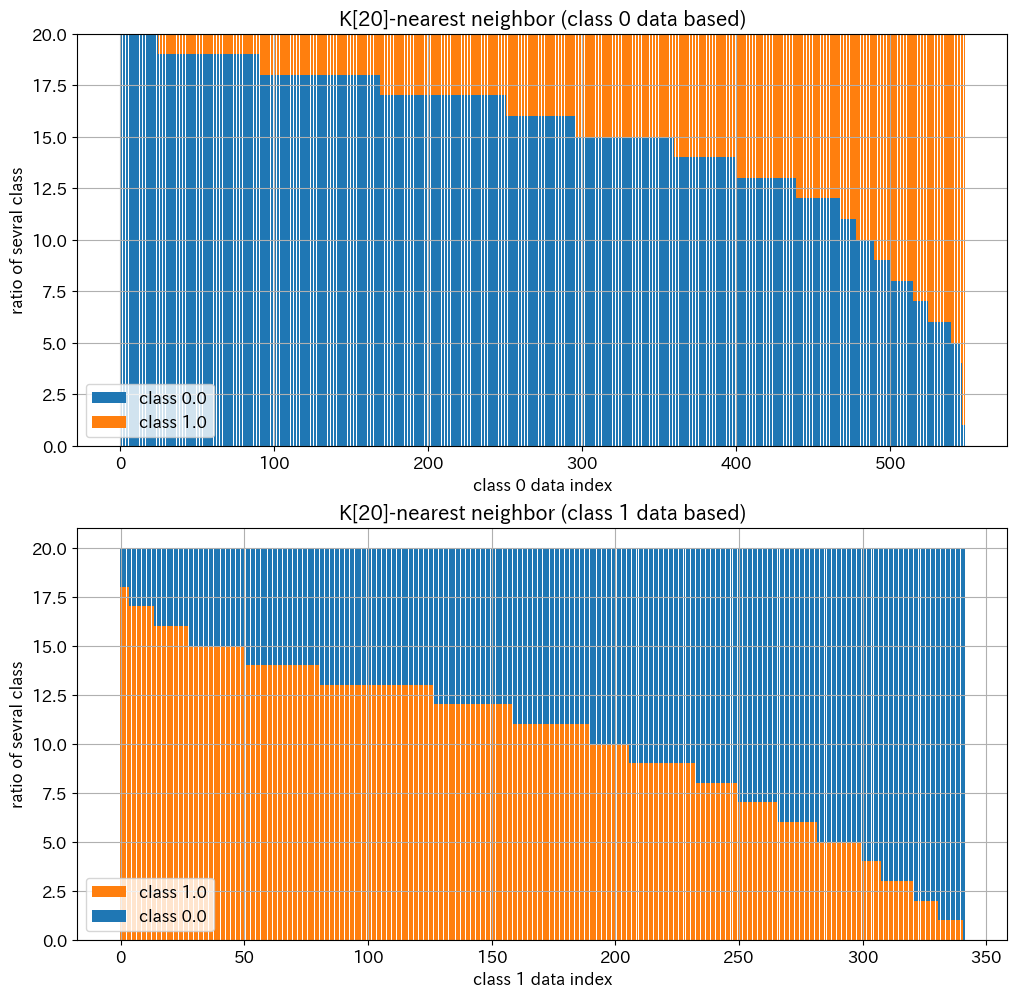

In [26]:
# [STEP 12-1] 
# judge predictable or not by knn
_ = ppap_tab_ut.knn_classification(X              = X, 
                                   y              = y, 
                                   X_outlier_care = True)


k-nn searching on positive data [start time is 2019-07-09 19:03:13.014927]
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
                                [end time is 2019-07-09 19:03:13.247124]



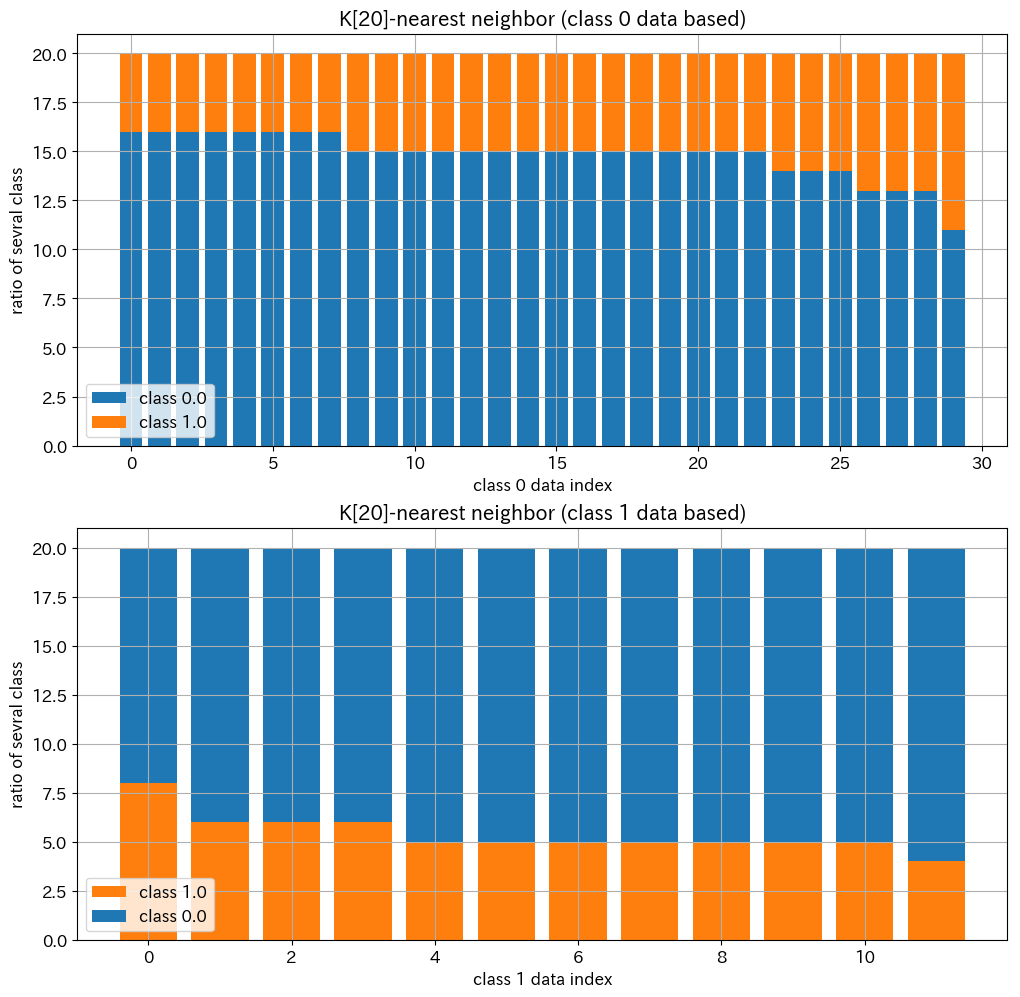

In [27]:
# [STEP 12-2] 
# judge predictable or not by knn
_ = ppap_tab_ut.knn_classification(X              = X[kmeans_result.labels_ == idx_sort_k[7]], 
                                   y              = y[kmeans_result.labels_ == idx_sort_k[7]], 
                                   X_outlier_care = True)


# learning

In [28]:
# separate train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
print('np.shape(X_train) = (%d, %d)' % np.shape(X_train))
print('np.shape(y_train) = (%d)'     % np.shape(y_train))
print('np.shape(X_test)  = (%d, %d)' % np.shape(X_test))
print('np.shape(y_test)  = (%d)'     % np.shape(y_test))


np.shape(X_train) = (445, 123)
np.shape(y_train) = (445)
np.shape(X_test)  = (446, 123)
np.shape(y_test)  = (446)


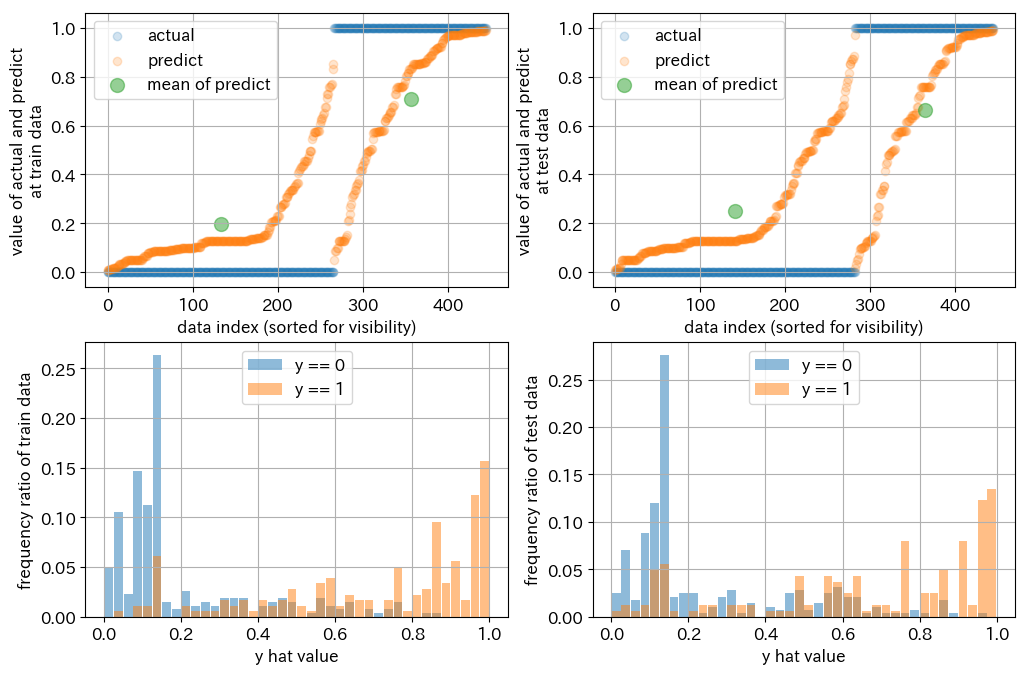

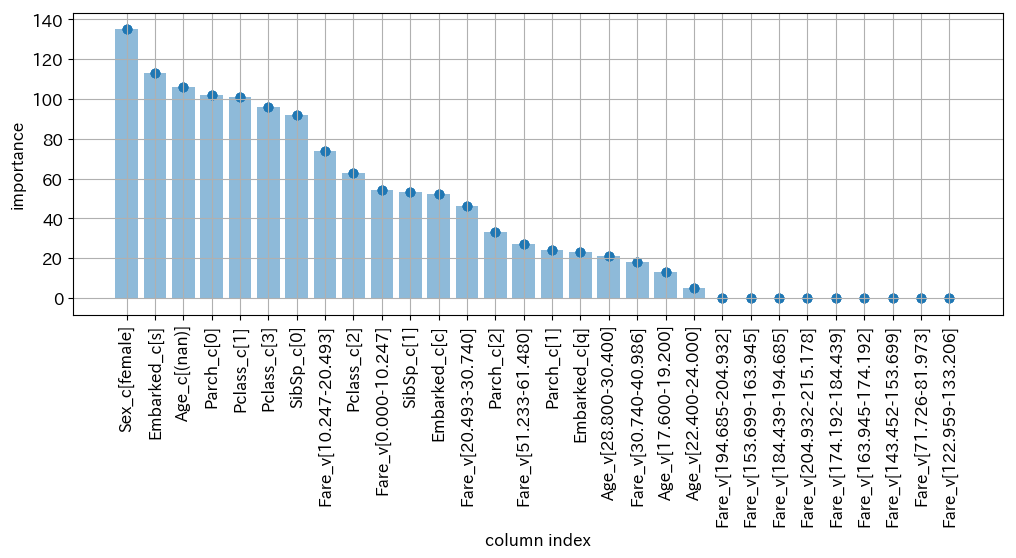

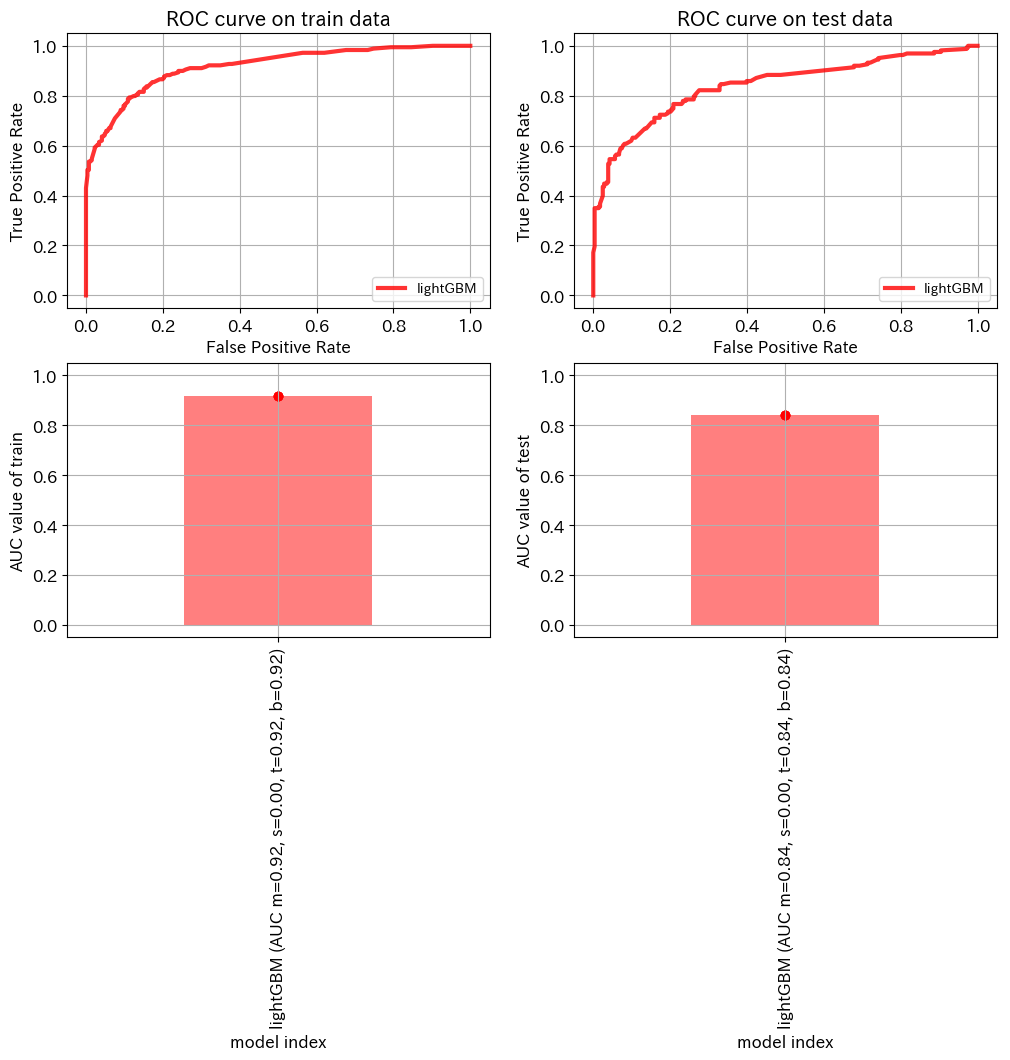

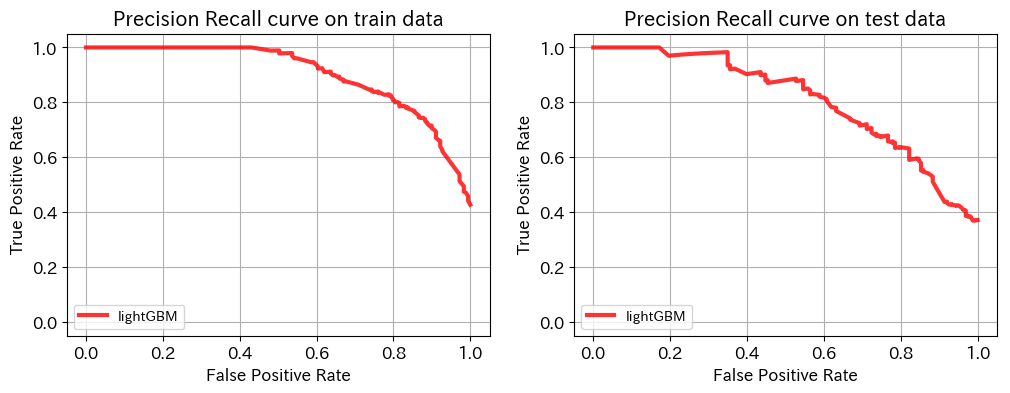

In [34]:
# [STEP 1]
# train and predict by one model 
model = LGBMClassifier(objective     = 'binary',  
                       learning_rate = 0.1, 
                       n_estimators  = 100, 
                       random_state  = 0, 
                       n_jobs        = 4) 

# exec
(model, 
 y_train_hat, 
 y_test_hat, 
 X_train_up, 
 y_train_up) = ppap_tab_2c.train_predict_and_measure(X_train        = X_train,
                                                     y_train        = y_train,
                                                     X_test         = X_test,
                                                     y_test         = y_test, 
                                                     model          = model, 
                                                     column_name    = column_name, 
                                                     alpha          = 0.2)


In [ ]:
# [STEP 2]
# cross validation by multi model and rfe
model      = []
model_name = []

# set common param
# rfe_step   = [800, 600, 400, 200, 100, 50, 30, 20, 15, 10, 5]
rfe_step   = []

# 1. lightGBM
param = [[0.1, 100, 0.1, 20, 0.5, 2.0], 
         [0.1, 100, 0.3, 15, 0.3, 4.0], 
         [0.1, 100, 0.5, 10, 0.1, 6.0]]
for param_i in range(len(param)):
    model_tmp = LGBMClassifier(objective        = 'binary',  
                               learning_rate    = param[param_i][0], 
                               n_estimators     = param[param_i][1], 
                               min_child_weight = param[param_i][2],
                               num_leaves       = param[param_i][3],
                               colsample_bytree = param[param_i][4],
                               reg_lambda       = param[param_i][5],
                               subsample        = 0.3, 
                               random_state     = 0, 
                               n_jobs           = 4) 
    model.append(model_tmp)
    model_name.append('lightGBM(l:%.2f,n:%d)' % (param[param_i][0], param[param_i][1]))

# 2. XGBoost
param = [[0.1, 100, 0.1, 5, 0.5, 2.0], 
         [0.1, 100, 0.3, 4, 0.3, 4.0], 
         [0.1, 100, 0.5, 3, 0.1, 6.0]]
for param_i in range(len(param)):
    model_tmp = XGBClassifier(learning_rate    = param[param_i][0], 
                              n_estimators     = param[param_i][1], 
                              min_child_weight = param[param_i][2],
                              max_depth        = param[param_i][3],
                              colsample_bytree = param[param_i][4],
                              reg_lambda       = param[param_i][5],
                              subsample        = 0.3, 
                              random_state     = 0, 
                              n_jobs           = 4) 
    model.append(model_tmp)
    model_name.append('XGBoost(l:%.2f,n:%d,d:%d)' % (param[param_i][0], param[param_i][1], param[param_i][2]))

# 3. LogisticRegression
param = [[0.01], 
         [0.1], 
         [1.0]]
for param_i in range(len(param)):
    model_tmp = LogisticRegression(C      = param[param_i][0],
                                   solver = 'sag', 
                                   n_jobs = 4)
    model.append(model_tmp)
    model_name.append('LogReg(C:%.2f)' % (param[param_i][0]))

# exec
(importance_stock, 
 rfe_step, 
 remain_idx, 
 model_name_stock, 
 idx_sort_auc_test) = ppap_tab_2c.rfe_and_cv(X              = X, 
                                             y              = y, 
                                             model          = model, 
                                             model_name     = model_name, 
                                             column_name    = column_name,
                                             sample_balance = True, 
                                             rfe_step       = rfe_step, 
                                             draw_cv_ratio  = 0.0)

plt.show()


In [ ]:
# [STEP 3]
# do the learning by good param setting 
rank_i       = 0 # choise method that column is small 

# 
model_i      = int(np.floor(idx_sort_auc_test[rank_i] / len(rfe_step)))
model_name_i = idx_sort_auc_test[rank_i]
rfe_step_i   = int(idx_sort_auc_test[rank_i] % len(rfe_step))

# 
model_       = model[model_i]
model_name_  = model_name_stock[idx_sort_auc_test[rank_i]]
model_name_  = model_name_[(model_name_.find('] ') + 2):]
model_name_  = model_name_[:model_name_.find('_RFE')]

# 
remain_idx_  = remain_idx[:, model_i, rfe_step_i]
X_slim       = X[:, remain_idx_]
column_name_ = column_name[remain_idx_]

# 
importance_  = np.mean(importance_stock[:, :, model_i, rfe_step_i], axis=1)

# 
print('model is ...')
print(model_)
print('')
print('use feature is ...')
for column_i in np.argsort(-importance_):
    if (remain_idx_[column_i]):
        print('  - %s : %.2f' % (column_name[column_i], importance_[column_i]))
print('')

# exec
(_, _, _, _, _) = ppap_tab_2c.cv_random(X              = X_slim, 
                                        y              = y, 
                                        model          = model_, 
                                        model_name     = model_name_, 
                                        column_name    = column_name_,
                                        sample_balance = True)


In [ ]:
# [Step 4-1]
# try discretization for check wrong data
X_slim           = X[:, remain_idx_]
column_name_slim = column_name[remain_idx_]

# separate train data and test data
(X_train_slim, X_test_slim, 
 y_train, y_test) = train_test_split(X_slim, y, test_size=0.5, random_state=0)

# # exec
# (learned_model, 
#  y_train_hat, 
#  y_test_hat, 
#  X_train_up, 
#  y_train_up) = ppap_tab_2c.train_predict_and_measure(X_train        = X_train_slim,
#                                                      y_train        = y_train,
#                                                      X_test         = X_test_slim,
#                                                      y_test         = y_test, 
#                                                      model          = model_, 
#                                                      column_name    = column_name, 
#                                                      sample_balance = True)

# exec
(learned_model, 
 y_train_hat, 
 y_test_hat, 
 X_train_up, 
 y_train_up) = ppap_tab_2c.train_predict_and_measure(X_train        = X_slim,
                                                     y_train        = y,
                                                     X_test         = X_slim,
                                                     y_test         = y, 
                                                     model          = model_, 
                                                     column_name    = column_name, 
                                                     sample_balance = False)


In [ ]:
# [Step 4-2]
# search large mistake

# # knn search
# (nearest_info) = ppap_tab_ut.knn_mistake_search(X           = X_test_slim, 
#                                                 y           = y_test, 
#                                                 y_hat       = y_test_hat, 
#                                                 column_name = column_name_slim, 
#                                                 k           = 50, 
#                                                 X_normalize = False)

# knn search
(nearest_info) = ppap_tab_ut.knn_mistake_search(X           = X_slim, 
                                                y           = y, 
                                                y_hat       = y_test_hat, 
                                                column_name = column_name_slim, 
                                                k           = 50, 
                                                X_normalize = False)

# view
nearest_info[0].T


In [ ]:
# 
pd.DataFrame(X_slim, columns=column_name_slim).describe()

# 
df_Xy.loc[[int(nearest_info[0].loc['data index', 'base']), 
           int(nearest_info[0].loc['data index', 'neighbor1']), 
           int(nearest_info[0].loc['data index', 'neighbor2']), 
           int(nearest_info[0].loc['data index', 'neighbor3']), 
           int(nearest_info[0].loc['data index', 'neighbor4']), 
           int(nearest_info[0].loc['data index', 'neighbor5']), 
           int(nearest_info[0].loc['data index', 'neighbor6']), 
           int(nearest_info[0].loc['data index', 'neighbor7']), 
           int(nearest_info[0].loc['data index', 'neighbor8']), 
           int(nearest_info[0].loc['data index', 'neighbor9']), 
           int(nearest_info[0].loc['data index', 'neighbor10']), 
           int(nearest_info[0].loc['data index', 'neighbor11']), 
           int(nearest_info[0].loc['data index', 'neighbor12']), 
           int(nearest_info[0].loc['data index', 'neighbor13']), 
           int(nearest_info[0].loc['data index', 'neighbor14']), 
           int(nearest_info[0].loc['data index', 'neighbor15']), 
           int(nearest_info[0].loc['data index', 'neighbor16']), 
           int(nearest_info[0].loc['data index', 'neighbor17']), 
           int(nearest_info[0].loc['data index', 'neighbor18']), 
           int(nearest_info[0].loc['data index', 'neighbor19']), 
           int(nearest_info[0].loc['data index', 'neighbor20']), 
           int(nearest_info[0].loc['data index', 'neighbor21']), 
           int(nearest_info[0].loc['data index', 'neighbor22']), 
           int(nearest_info[0].loc['data index', 'neighbor23']), 
           int(nearest_info[0].loc['data index', 'neighbor24']), 
           int(nearest_info[0].loc['data index', 'neighbor25']), 
           int(nearest_info[0].loc['data index', 'neighbor26']), 
           int(nearest_info[0].loc['data index', 'neighbor27']), 
           int(nearest_info[0].loc['data index', 'neighbor28']), 
           int(nearest_info[0].loc['data index', 'neighbor29']), 
           int(nearest_info[0].loc['data index', 'neighbor30']), 
           int(nearest_info[0].loc['data index', 'neighbor31']), 
           int(nearest_info[0].loc['data index', 'neighbor32']), 
           int(nearest_info[0].loc['data index', 'neighbor33']), 
           int(nearest_info[0].loc['data index', 'neighbor34']), 
           int(nearest_info[0].loc['data index', 'neighbor35'])], :]


In [ ]:
# view
nearest_info[2].T


In [ ]:
# 
pd.DataFrame(X_slim, columns=column_name_slim).describe()

# 
df_Xy.loc[[int(nearest_info[2].loc['data index', 'base']), 
           int(nearest_info[2].loc['data index', 'neighbor1']), 
           int(nearest_info[2].loc['data index', 'neighbor2'])], :]


In [ ]:
# [STEP 3]
# do the learning by good param setting 
rank_i       = 4 # choise method that column is small 

# 
model_i      = int(np.floor(idx_sort_auc_test[rank_i] / len(rfe_step)))
model_name_i = idx_sort_auc_test[rank_i]
rfe_step_i   = int(idx_sort_auc_test[rank_i] % len(rfe_step))

# 
model_       = model[model_i]
model_name_  = model_name_stock[idx_sort_auc_test[rank_i]]
model_name_  = model_name_[(model_name_.find('] ') + 2):]
model_name_  = model_name_[:model_name_.find('_RFE')]

# 
remain_idx_  = remain_idx[:, model_i, rfe_step_i]
X_slim       = X[:, remain_idx_]
column_name_ = column_name[remain_idx_]

# 
importance_  = np.mean(importance_stock[:, :, model_i, rfe_step_i], axis=1)

# 
print('model is ...')
print(model_)
print('')
print('use feature is ...')
for column_i in np.argsort(-np.abs(importance_)):
    if (remain_idx_[column_i]):
        print('  - %s : %.2f' % (column_name[column_i], importance_[column_i]))
print('')

# exec
(_, _, _, _, _) = ppap_tab_2c.cv_random(X                    = X_slim, 
                                        y                    = y, 
                                        model                = model_, 
                                        model_name           = model_name_, 
                                        column_name          = column_name_,
                                        sample_balance       = True, 
                                        draw_importance_rank = 50)


In [ ]:
# [Step 4-3]
# try to make reduce mistake
